# [Kaggle - Weather time series](https://www.kaggle.com/datasets/smid80/weatherww2?select=Summary+of+Weather.csv)

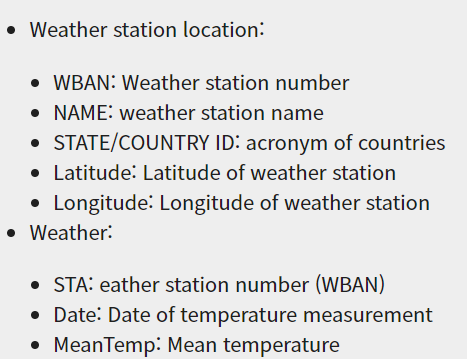

#### 참고 사이트
[[Python] 날씨 시계열 데이터(kaggle)로 ARIMA 적용하기](https://leedakyeong.tistory.com/entry/Python-%EB%82%A0%EC%94%A8-%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%8D%B0%EC%9D%B4%ED%84%B0Kaggle%EB%A1%9C-ARIMA-%EC%A0%81%EC%9A%A9%ED%95%98%EA%B8%B0)  
[[ML/Python]시계열 데이터, 주식데이터 분석예측, ARIMA](https://velog.io/@isitcake_yes/mlarimastockprediction)  

In [57]:
import pandas as pd
import seaborn as ans
import numpy as anp
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus']=False

### 데이터 불러오기

In [58]:
weather = pd.read_csv(os.getcwd() + '/data/weather time series/Summary of Weather.csv')
weather_station_location = pd.read_csv(os.getcwd() + '/data/weather time series/Weather Station Locations.csv')

print(weather.columns)
print(weather_station_location.columns)

Index(['STA', 'Date', 'Precip', 'WindGustSpd', 'MaxTemp', 'MinTemp',
       'MeanTemp', 'Snowfall', 'PoorWeather', 'YR', 'MO', 'DA', 'PRCP', 'DR',
       'SPD', 'MAX', 'MIN', 'MEA', 'SNF', 'SND', 'FT', 'FB', 'FTI', 'ITH',
       'PGT', 'TSHDSBRSGF', 'SD3', 'RHX', 'RHN', 'RVG', 'WTE'],
      dtype='object')
Index(['WBAN', 'NAME', 'STATE/COUNTRY ID', 'LAT', 'LON', 'ELEV', 'Latitude',
       'Longitude'],
      dtype='object')


In [59]:
# 필요한 변수만 추출
weather = weather[['STA', 'Date', 'MeanTemp']]           
weather_station_location = weather_station_location[['WBAN', 'NAME', 'STATE/COUNTRY ID', 'Latitude', 'Longitude']]
          
display(weather.head())
display(weather_station_location.head())

,STA,Date,MeanTemp
0,10001,1942-7-1,23.888889
1,10001,1942-7-2,25.555556
2,10001,1942-7-3,24.444444
3,10001,1942-7-4,24.444444
4,10001,1942-7-5,24.444444


,WBAN,NAME,STATE/COUNTRY ID,Latitude,Longitude
0,33013,AIN EL,AL,36.383333,6.650000
1,33031,LA SENIA,AL,35.616667,0.583333
2,33023,MAISON BLANCHE,AL,36.716667,3.216667
3,33044,TELERGMA,AL,36.116667,6.416667
4,12001,TINDOUF,AL,27.683333,-8.083333


In [7]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119040 entries, 0 to 119039
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   STA       119040 non-null  int64  
 1   Date      119040 non-null  object 
 2   MeanTemp  119040 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.7+ MB


In [8]:
weather_station_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   WBAN              161 non-null    int64  
 1   NAME              161 non-null    object 
 2   STATE/COUNTRY ID  161 non-null    object 
 3   Latitude          161 non-null    float64
 4   Longitude         161 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 6.4+ KB


### BINDUKURI 지역에 대한 일 평균 온도를 대상으로 분석 진행

In [9]:
# BINDUKURI 지역 데이터만 추출
weather_station_id = weather_station_location[weather_station_location.NAME=='BINDUKURI'].WBAN # index 번호 추출
weather_bin = weather[weather.STA == int(weather_station_id)]

# Date 변수를 datetime 형으로 변환
weather['Date'] = pd.to_datetime(weather['Date'], format='%Y-%m-%d')
weather_bin.head(3)

,STA,Date,MeanTemp
78252,32907,1943-5-11,28.888889
78253,32907,1943-5-12,25.555556
78254,32907,1943-5-13,24.444444


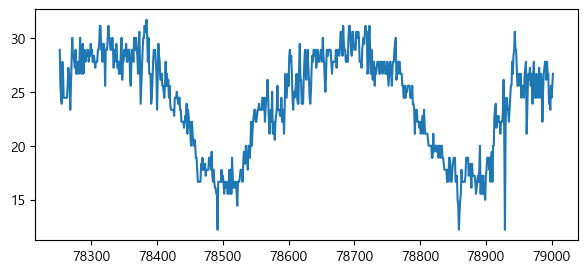

In [10]:
# BINDUKURI 지역의 시계열 그래프
plt.figure(figsize=(7,3))
plt.plot(weather_bin.index, weather_bin['MeanTemp']);

In [63]:
# 시계열 형태의 ts 데이터 생성
timeSeries = weather_bin[['Date', 'MeanTemp']]
timeSeries.index = timeSeries.Date
ts = timeSeries.drop('Date', axis=1)
display(ts.head(3))

,MeanTemp
Date,
1943-5-11,28.888889
1943-5-12,25.555556
1943-5-13,24.444444


### 시계열 분해

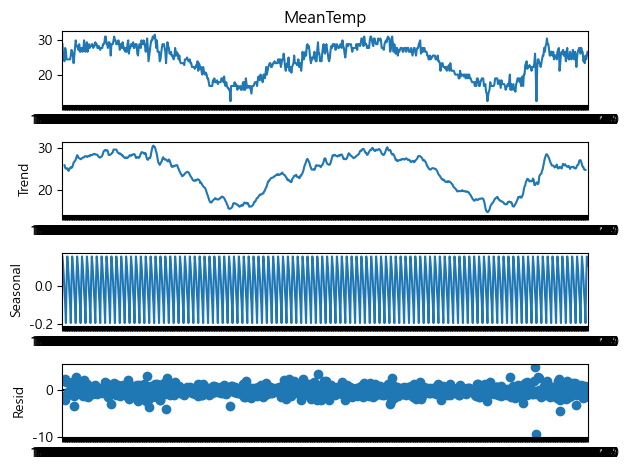

In [148]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts['MeanTemp'], model = 'additive', period=7)
result.plot();

### 시계열 정상성 확인
#### 1) ACF 그래프를 통해 확인하는 방법  
#### 2) ADF 검정

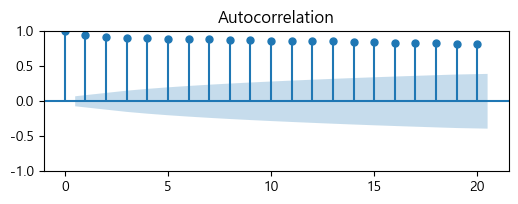

In [64]:
# 정상성 확인1(ACF 그래프)
## 그래프 값이 천천히 작아지므로 정상성을 만족하지 않음
from statsmodels.graphics.tsaplots import plot_acf
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(211)
fig = plot_acf(ts, lags=20, ax=ax1)

In [68]:
# 정상성 확인2(ADF 검정)
## 귀무가설: 데이터가 정상성을 갖지 않는다.
## 대립가설: 데이터가 정상성을 갖는다.
from statsmodels.tsa.stattools import adfuller

## training, test data 구분
training = ts.iloc[:650]
test = ts.drop(training.index)

## ADF 검정
adf = adfuller(training, regression='ct')
print('ADF Staticstic: {}'.format(adf[0]))
print('p-value: {}'.format(adf[1]))

ADF Staticstic: -1.0061996008171106
p-value: 0.9432744583038727


p-value > 0.05 이므로 귀무가설을 기각할 수 없기에 데이터는 정상성을 갖지 않는다. 따라서 정상성을 확보하기 위해 차분 또는 변환을 진행한다.

### 정상성을 만족하기 위한 차분 진행

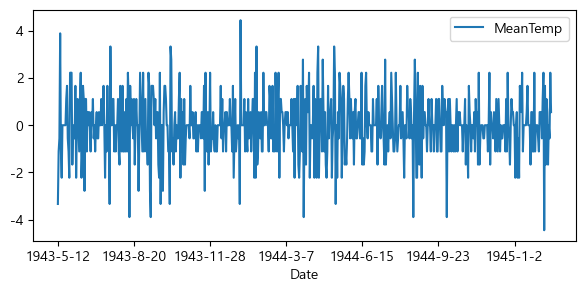

In [69]:
diff_data = training.diff(1).dropna() # 1차 차분
diff_data.plot(figsize=(7,3));

In [70]:
# 1차 차분한 데이터로 ADF 검정
## 결과: p-value < 0.05 이므로 귀무가설을 기각하여 1차 차분한 데이터는 정상성을 만족한다고 할 수 있다.
adf = adfuller(diff_data[1:])
print('ADF Staticstic: {}'.format(adf[0]))
print('p-value: {}'.format(adf[1]))

ADF Staticstic: -10.97593185819673
p-value: 7.670102752132856e-20


### ARIMA(p, d, q) 모수 추정
#### 1) ACF, PACF 그래프를 통한 p, q 값 추청  
#### 2) pmdarima 라이브러리의 ndiffs, auto_arima 함수를 사용한 모수 추정

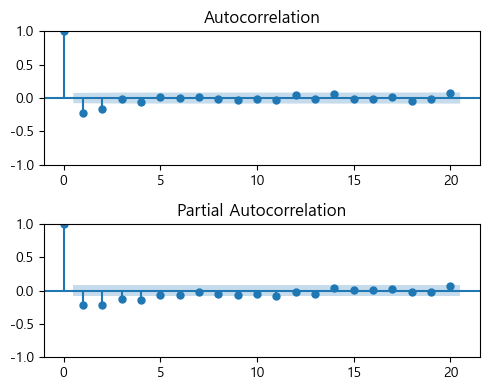

In [74]:
# 1) ACF, PACF 그래프를 통해 p, q 값 추정
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(5, 4))
ax1 = fig.add_subplot(211)
fig = plot_acf(diff_data, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(diff_data, lags=20, ax=ax2)
plt.tight_layout();

[해석]
- ACF와 PACF 모두 금방 0에 수렴하고, ACF 그래프는 두 번째 lag 이후 0에 수렴하고 PACF 그래프는 네 번째 lag 이후에 0에 수렴한다.
- 따라서 ARIMA(2,1,2) 모형을 base model로, ARIMA(2,1,1), ARIMA(1,1,2) 등의 모델을 시도해볼 수 있다.

In [81]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(training, order=(2,1,4))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               MeanTemp   No. Observations:                  650
Model:                 ARIMA(2, 1, 4)   Log Likelihood               -1035.269
Date:                Sun, 25 Jun 2023   AIC                           2084.539
Time:                        15:54:18   BIC                           2115.867
Sample:                             0   HQIC                          2096.691
                                - 650                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1850      0.833     -0.222      0.824      -1.817       1.447
ar.L2          0.0724      0.661      0.110      0.913      -1.223       1.367
ma.L1         -0.1529      0.832     -0.184      0.854      -1.783       1.477
ma.L2         -0.3482      0.845     -0.412      0.680      -2.005       1.309
ma.L3         -0.0569      0.209     -0.272      0.786      -0.467       0.353
ma.L4         -0.0489      0.146     -0.335      0.737      -0.335       0.237
sigma2         1.4217      0.071     19.991      0.000       1.282       1.561
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 8.96
Prob(Q):                              0.96   Prob(JB):                         0.01
Heteroskedasticity (H):               0.68   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 잔차 검정
- 잔차가 정상성(백색잡음인지), 정규성, 등분산성 등을 만족하는지 파악한다.
- Ljung-Box (Q), Heteroskedasticity (H), Jarque-Bera (JB)에 대한 부분은 모두 **잔차에 대한 검정 통계량**이다.
    - Ljung-Box (Q)
        - 귀무가설: 잔차가 백색잡음이다.
        - Prob(Q)(=0.96) > 0.05 이므로 귀무가설을 채택할 수 있다.
        - 따라서 잔차가 자기 상관을 가지지 않는 백색잡음이며, 시계열 모형이 잘 적합되었다.
    - Heteroskedasticity (H)
        - 귀무가설: 잔차가 이분산을 띄지 않는다.
        - Prob(JB)(=0.00) <0.05 이므로 귀무가설을 기각한다.
        - 따라서 잔차가 이분산성을 띈다.
    - Jarque-Bera (JB)
        - 귀무가설: 잔차가 정규성을 만족한다.
        - Prob(JB)(=0.01) < 0.05 이므로 귀무가설을 기각한다.
        - 따라서 잔차가 정규성을 만족하지 않는다.

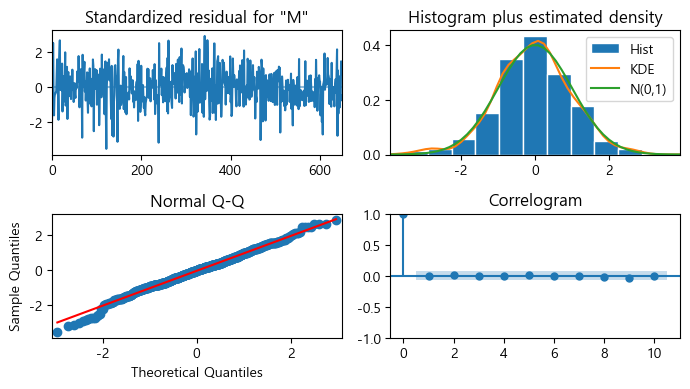

In [82]:
res.plot_diagnostics(figsize=(7, 4))
plt.tight_layout()
plt.show()

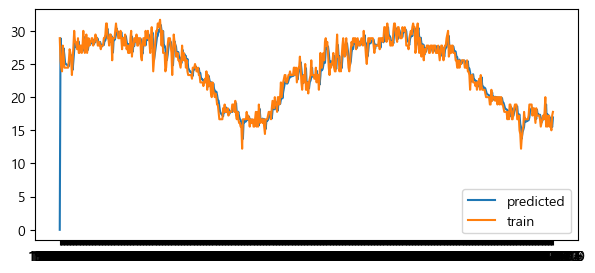

In [83]:
plt.figure(figsize=(7,3))
plt.plot(res.predict(), label = 'predicted') # 학습된 모델인 res에 학습시킨 데이터를 예측함.
plt.plot(training, label = 'train')
plt.legend(loc='lower right');

In [84]:
# 학습데이터세트로부터 test 데이터 길이만큼 예측
forecast_df = res.forecast(steps=len(test), alpha=.05)
pred_y = forecast_df
pred_y.index = test.index
pred_y

Date
1945-2-20    17.187655
1945-2-21    16.993547
1945-2-22    16.854774
1945-2-23    16.825381
1945-2-24    16.820773
               ...    
1945-5-27    16.819327
1945-5-28    16.819327
1945-5-29    16.819327
1945-5-30    16.819327
1945-5-31    16.819327
Name: predicted_mean, Length: 101, dtype: float64

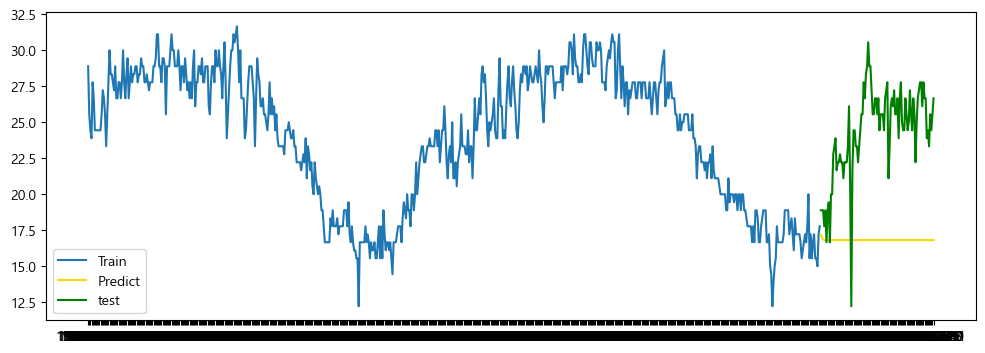

In [104]:
plt.figure(figsize=(12,4))
plt.plot(training, label='Train')
plt.plot(pred_y, color='gold', label='Predict')
plt.plot(test, color='green', label='test')
plt.legend();

In [86]:
from sklearn.metrics import mean_squared_error, r2_score
print('r2_score:', r2_score(test, pred_y))
RMSE = mean_squared_error(test, pred_y)**.5
print('RMSE:', RMSE)

r2_score: -5.922739231899419
RMSE: 8.117256714465867


In [92]:
# SARIMA 모델 사용
## ARIMA(2,1,4)의 성능이 좋지 않으므로 계절성까지 고려한 SARIMA 모델을 활용함
from pmdarima import auto_arima
auto_sarima = auto_arima(y=training, d=1,
                          start_p=0, max_p=3, start_q=0, max_q=3,
                        start_P=0, start_Q=0, max_P=3, max_Q=3, 
                          m=12, seasonal=True, setpwise=True, information_criterion='aic', trace=True)
print(auto_sarima.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2171.875, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2143.440, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2117.480, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2169.990, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2116.620, Time=0.16 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2117.584, Time=0.37 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=2116.632, Time=0.91 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2079.993, Time=0.41 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=2080.228, Time=0.70 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=2080.115, Time=0.62 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=2079.831, Time=1.39 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=3.39 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=4.24 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=2081.507, Time=1.77 sec
 ARIMA(1,1,1)(2,0,0)[12] inte

[잔차 검정]
- 잔차가 정상성(백색잡음인지), 정규성, 등분산성 등을 만족하는지 파악한다.
- Ljung-Box (Q), Heteroskedasticity (H), Jarque-Bera (JB)에 대한 부분은 모두 **잔차에 대한 검정 통계량**이다.
    - Ljung-Box (Q)
        - 귀무가설: 잔차가 백색잡음이다.
        - Prob(Q)(=0.64) > 0.05 이므로 귀무가설을 채택할 수 있다.
        - 따라서 잔차가 자기 상관을 가지지 않는 백색잡음이며, 시계열 모형이 잘 적합되었다.
    - Heteroskedasticity (H)
        - 귀무가설: 잔차가 이분산을 띄지 않는다.
        - Prob(JB)(=0.00) <0.05 이므로 귀무가설을 기각한다.
        - 따라서 잔차가 이분산성을 띈다.
    - Jarque-Bera (JB)
        - 귀무가설: 잔차가 정규성을 만족한다.
        - Prob(JB)(=0.05) > 0.05 이므로 귀무가설을 기각하지 못한다.
        - 따라서 잔차가 정규성을 만족한다.

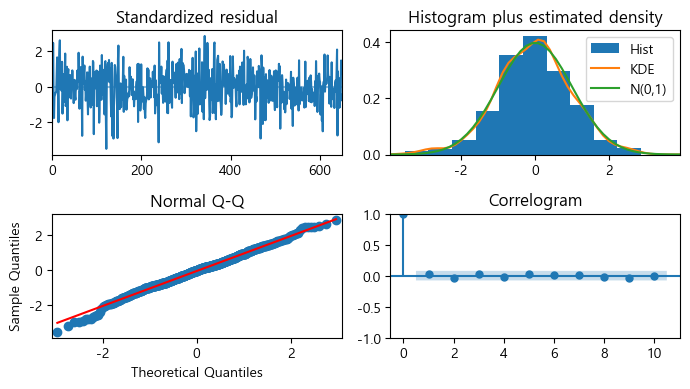

In [93]:
auto_sarima.plot_diagnostics(figsize=(7, 4))
plt.tight_layout()
plt.show()

In [107]:
# 학습데이터세트로부터 test 데이터 길이만큼 예측
sarima_pred_y = pd.DataFrame(auto_sarima.predict(n_periods=len(test)))
sarima_pred_y.index=test.index
sarima_pred_y.columns=['predicted_price'] 
sarima_pred_y.head()

,predicted_price
Date,
1945-2-20,17.417430
1945-2-21,17.210443
1945-2-22,16.968555
1945-2-23,17.024823
1945-2-24,17.056757


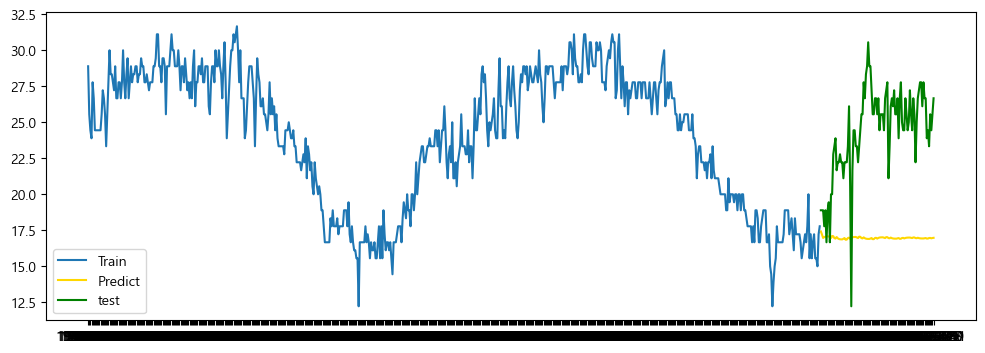

In [105]:
plt.figure(figsize=(12,4))
plt.plot(training, label='Train')
plt.plot(sarima_pred_y, color='gold', label='Predict')
plt.plot(test, color='green', label='test')
plt.legend();

In [101]:
from sklearn.metrics import mean_squared_error, r2_score
print('r2_score:', r2_score(test, sarima_pred_y))
RMSE = mean_squared_error(test, sarima_pred_y)**.5
print('RMSE:', RMSE)

r2_score: -5.70533867923375
RMSE: 7.988783540695014


In [96]:
# 2) pmdarima 라이브러리의 auto_arima 함수로 모수 추정하기
import pmdarima as pm
from pmdarima.arima import ndiffs
n_diffs = ndiffs(training,alpha=.5, test='adf', max_d=6)
print(f'추정된 차수 d = {n_diffs}\n')

auto_model = pm.auto_arima(y=training, d=n_diffs,
                          start_p=0, max_p=3, start_q=0, max_q=3,
                          m=1, seasonal=False, setpwise=True, 
                           trace=True)
print(auto_model.summary())

추정된 차수 d = 1

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2171.875, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2142.252, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2116.620, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2169.990, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2079.993, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2080.817, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2080.660, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2082.497, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2112.750, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2081.843, Time=0.60 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2078.855, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2114.919, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2140.415, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2079.651, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0

[최적의 모델]
- auto_arima 결과 최적의 모델은 ARIMA(1,1,1)(0,0,0) 모형으로 나왔다.

[잔차 검정]
- 잔차가 정상성(백색잡음인지), 정규성, 등분산성 등을 만족하는지 파악한다.
- Ljung-Box (Q), Heteroskedasticity (H), Jarque-Bera (JB)에 대한 부분은 모두 **잔차에 대한 검정 통계량**이다.
    - Ljung-Box (Q)
        - 귀무가설: 잔차가 백색잡음이다.
        - Prob(Q)(=0.63) > 0.05 이므로 귀무가설을 채택할 수 있다.
        - 따라서 잔차가 자기 상관을 가지지 않는 백색잡음이며, 시계열 모형이 잘 적합되었다.
    - Heteroskedasticity (H)
        - 귀무가설: 잔차가 이분산을 띄지 않는다.
        - Prob(JB)(=0.00) <0.05 이므로 귀무가설을 기각한다.
        - 따라서 잔차가 이분산성을 띈다.
    - Jarque-Bera (JB)
        - 귀무가설: 잔차가 정규성을 만족한다.
        - Prob(JB)(=0.01) < 0.05 이므로 귀무가설을 기각한다.
        - 따라서 잔차가 정규성을 만족하지 않는다.

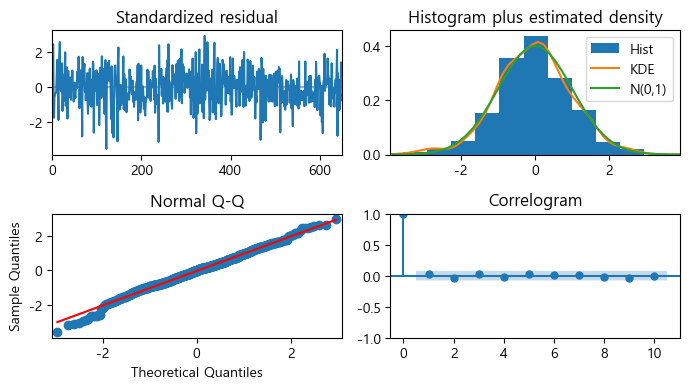

In [97]:
auto_model.plot_diagnostics(figsize=(7, 4))
plt.tight_layout()
plt.show()

- 해석1. 잔차의 정상성
    - Standardized residual(좌상단) : 잔차의 시계열 데이터. 잔차의 시계열이 평균 0을 중심으로 변동하는 것으로 보임.
    - Correlogram (우하단) : 잔차에 대한 ACF 플롯. 어느정도 허용 범위(파란박스) 안에 위치하여 자기상관이 없음을 알 수 있음.
- 해석2. 잔차의 정규성
    - Histogram plus estimated density (우상단) : 잔차의 히스토그램을 그려 정규분포(N(0,1))와 밀도를 추정한 그래프.
    - Normal Q-Q (좌하단) : 양끝쪽 빨간 선을 벗어나는 구간이 존재한다. 정규성을 만족하려면 빨간 일직선 위에 점들이 분포해야 함.
- 결론
    - 잔차는 백색잡음(정상성)이지만, 정규성과 등분산성을 만족하지 않는다. 따라서 추후 모형 설정에서 여러 파라미터들을 변경하거나 데이터를 변환해가며 모형을 테스트해본다.

In [98]:
# 학습데이터세트로부터 test 데이터 길이만큼 예측
auto_pred_y = pd.DataFrame(auto_model.predict(n_periods=len(test)))
auto_pred_y.index = test.index
auto_pred_y.columns = ['predicted_price']
auto_pred_y.head()

,predicted_price
Date,
1945-2-20,17.275509
1945-2-21,17.047843
1945-2-22,16.944647
1945-2-23,16.897871
1945-2-24,16.876669


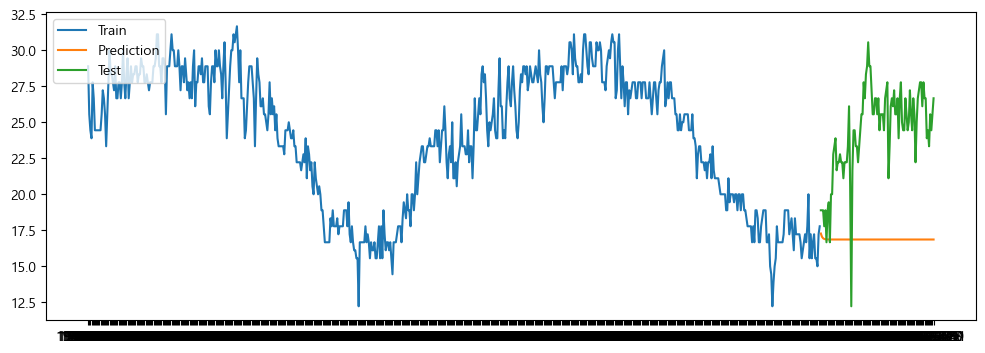

In [106]:
# 예측값과 실제 test 데이터 간 차이를 시각화
plt.figure(figsize=(12,4))
plt.plot(training, label='Train')
plt.plot(auto_pred_y, label='Prediction')
plt.plot(test, label='Test')
plt.legend(loc='upper left')
plt.show()

In [100]:
from sklearn.metrics import mean_squared_error, r2_score
print('r2_score:', r2_score(test, auto_pred_y))
RMSE = mean_squared_error(test, auto_pred_y)**.5
print('RMSE:', RMSE)

r2_score: -5.859628219849562
RMSE: 8.080171596268231
